<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import matplotlib.pyplot as plt
import os,math, random
from skimage.transform import resize as sc_resize
import matplotlib.pyplot as plt
import cv2
from skimage import io
import numpy as np
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

import tensorflow as tf
from tensorflow import keras as K
from tensorflow.keras.preprocessing.image import load_img
%matplotlib inline
plt.rcParams['image.cmap']='gray'
tf.random.set_seed(1000)
np.random.seed(1000)
plt.ion()

In [2]:
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0  13.4M      0  0:00:55  0:00:55 --:--:-- 14.5M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.2M  100 18.2M    0     0  4873k      0  0:00:03  0:00:03 --:--:-- 4872k


In [3]:
input_dir = "./images/"
target_dir = "./annotations/trimaps/"
input_img_paths=sorted(
                    [ os.path.join(input_dir,img_name)for img_name in os.listdir(input_dir) if img_name.endswith('.jpg') ]
                    )

target_img_paths=sorted(
                  [ os.path.join(target_dir,tar_img_name) for tar_img_name in os.listdir(target_dir)
                   if tar_img_name.endswith('.png') and not tar_img_name.startswith('.')
                  ])
len(input_img_paths)

7390

In [4]:
K.backend.clear_session()
img_size = (160,160)
num_classes = 3
batch_size = 50


In [5]:

class OxfordPetsDateset(K.utils.Sequence):
    def __init__(self,batch_size,img_size,input_img_paths,target_img_paths):
        self.batch_size=batch_size
        self.img_size=img_size
        self.input_img_paths=input_img_paths
        self.target_img_paths=target_img_paths
        
        
    def __len__(self):
        return len(self.target_img_paths)//self.batch_size
    
    def __getitem__(self,idx):
        batch_input_img_paths=self.input_img_paths[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_target_img_paths=self.target_img_paths[idx*self.batch_size:(idx+1)*self.batch_size]

        batch_x=np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        batch_y=np.zeros((self.batch_size,)+self.img_size+(1,),dtype='uint8')
        
        for i,img in enumerate(batch_input_img_paths):
            img=load_img(img, target_size=self.img_size)
            img/=np.max(img)
            batch_x[i]=img
            
        for i,img in enumerate(batch_target_img_paths):
            img=load_img(img, target_size=self.img_size, color_mode="grayscale")
            batch_y[i]=np.expand_dims(img,axis=2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            batch_y[i]-=1
        return batch_x,batch_y
        


In [6]:

# Split our img paths into a training and a validation set
val_samples = 1000
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]
# Instantiate data Sequences for each split
train_data = OxfordPetsDateset(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_data = OxfordPetsDateset(batch_size, img_size, val_input_img_paths, val_target_img_paths)

# MODEL
We will implement a U-Net-like architecture but with fewer layers

In [7]:
K.backend.clear_session()
input_shape = (160,160, 3)

In [8]:
net=K.Sequential([
    K.layers.InputLayer(input_shape=input_shape),
    K.layers.Conv2D(64,kernel_size=3),
    K.layers.BatchNormalization(),
    K.layers.Activation('relu'),
    K.layers.MaxPooling2D(pool_size=2,strides=2),
    
    K.layers.InputLayer(input_shape=input_shape),
    K.layers.Conv2D(128,kernel_size=3,padding='same'),
    K.layers.BatchNormalization(),
    K.layers.Activation('relu'),
    K.layers.MaxPooling2D(pool_size=2),
    
    K.layers.Conv2D(100,kernel_size=5),
    K.layers.BatchNormalization(),
    K.layers.Activation('relu'),
    
    K.layers.Conv2D(100,kernel_size=5),
    K.layers.BatchNormalization(),
    K.layers.Activation('relu'),
    K.layers.UpSampling2D(),
    
    K.layers.Conv2D(100,kernel_size=5,strides=2),
    K.layers.BatchNormalization(),
    K.layers.Activation('relu'),
    K.layers.UpSampling2D(),
    
    K.layers.Conv2D(100,kernel_size=5),
    K.layers.BatchNormalization(),
    K.layers.Activation('relu'),
    K.layers.UpSampling2D(3),
    
    K.layers.Conv2D(100,kernel_size=5),
    K.layers.BatchNormalization(),
    K.layers.Activation('relu'),
    K.layers.Conv2DTranspose(64,3),
    K.layers.BatchNormalization(),
    K.layers.Activation('relu'),
    K.layers.Conv2D(3,1,padding='same',activation ='softmax')
])
net.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 158, 158, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 158, 158, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 158, 158, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 79, 79, 64)       0         
 )                                                               
                                                                 
 input_2 (InputLayer)        multiple                  0         
                                                                 
 conv2d_1 (Conv2D)           (None, 79, 79, 128)       7

In [9]:
net.compile(optimizer = K.optimizers.Adam(learning_rate = 1e-4), loss = 'sparse_categorical_crossentropy')

In [ ]:
#net.fit(train_data,target_data,steps_per_epoch=1000,epochs=20)
net.fit(train_data,epochs=25,validation_data=val_data)

Epoch 1/25
127/127 [==============================] - 93s 639ms/step - loss: 0.9105 - val_loss: 0.9000
Epoch 2/25
127/127 [==============================] - 82s 642ms/step - loss: 0.8101 - val_loss: 1.0234
Epoch 3/25
127/127 [==============================] - 82s 646ms/step - loss: 0.7634 - val_loss: 0.8806
Epoch 4/25
127/127 [==============================] - 82s 646ms/step - loss: 0.7402 - val_loss: 0.7592
Epoch 5/25
127/127 [==============================] - 82s 649ms/step - loss: 0.7146 - val_loss: 0.6890
Epoch 6/25
127/127 [==============================] - 83s 650ms/step - loss: 0.6908 - val_loss: 0.6852
Epoch 7/25
127/127 [==============================] - 83s 649ms/step - loss: 0.6836 - val_loss: 0.6588
Epoch 8/25
127/127 [==============================] - 83s 649ms/step - loss: 0.6718 - val_loss: 0.7038
Epoch 9/25
127/127 [==============================] - 82s 648ms/step - loss: 0.6557 - val_loss: 0.6784
Epoch 10/25
127/127 [==============================] - 83s 650ms/step - l

In [14]:
net.save("unet_model_OxfordPet.h5")

In [15]:
model=K.models.load_model("unet_model_OxfordPet.h5")

In [16]:
# Generate predictions for all images in the validation set

val_gen = OxfordPetsDateset(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)

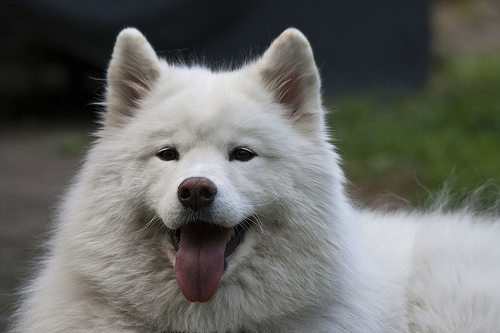

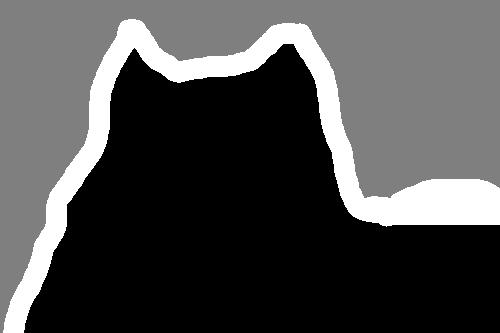

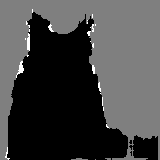

In [24]:
def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(K.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 7

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.

# References


[A guide to convolution arithmetic for deep learning,2018](https://arxiv.org/abs/1603.07285)

[Is the deconvolution layer the same as a convolutional layer?,2016](https://arxiv.org/ftp/arxiv/papers/1609/1609.07009.pdf)

[13.11. Fully Convolutional Networks](https://d2l.ai/chapter_computer-vision/fcn.html)


